In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

In [2]:
class test:
    def __init__(self, composed = 0, parametros ={}, lamb = None, target_param = ""):
        self.composed = composed
        self.parametros = parametros
        self.lamd = lamb
        self.target_param = target_param
    def eval(funct):
        return {"eval": funct}

In [3]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.2                                     # LDO output voltage
Vin = 1.8                                      # LDO supply voltage
Vref = 0.9                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 50e-12                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

# Initial macros

In [4]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 1.8, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.05,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 0.95}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff"), Symbol("L_diff"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

# Primitives

In [5]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-1.8, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro/(IL/20e-6)).flatten()}
pt.outputs = {Symbol("W"): np.asarray(pt.W).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-1.8, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': 20e-6,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W"): np.asarray(stage2_t.W).flatten()}

## OTA stage1 differential pair

vs = np.linspace(0.1, 0.8, 20)
vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

diffpair_primitive = simplediffpair(netlist='simplediffpair', type='nmos', inputs={'vds_lut': (0.1, 1.2, 0.01), 'vgs_lut': (0.1, 1.8, 0.01), 'vds': vds_diffpar, 'vgs': vgs_diffpar, 'il': 20e-6,
                  'length': lengths, '2d_var': ['vds', 'vgs']})

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff"): np.asarray(diffpair_primitive.W).flatten(),
                              Symbol("L_diff"): np.asarray(diffpair_primitive.L).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': 20e-6,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("Raload_2"): 1/np.asarray(ota_cm_pmos.gm).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0


# Specifications

In [6]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 0.9,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.name = "psrr_2stage"
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "stage2_OTA"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}

psrr_2stage_OTA.opt_goal = "max"
psrr_2stage_OTA.conditions = {"min": [10**(30/20)]}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "stage2_OTA"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "stage2_OTA_r"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [4.641589e+05]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

#################### gm 2 stage OTA #######################

gm_2stage_OTA = test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "V_p"]
gm_2stage_OTA.netlist = "stage2_OTA"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [psrr_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"

gm_2stage_OTA.conditions = {"min": [0.001]}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "OTA_cap"
psrr_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Cl"): 1e-12}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.netlist = "OTA_cap"
bw_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 1,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"eval": bw_1stage_OTA.tf}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "OTA_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                   Symbol("Rdif_2"): Symbol("Rdif_1"),
                   Symbol("V1"): 0,
                   Symbol("V_n"): 0,
                   Symbol("V_p"): 0,
                   Symbol("Vr"): 1,
                   Symbol("I2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rr"): 1000,
                   Symbol("Cl"): 1e-12}
rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+03]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}



# Sizes

# Exploration

In [7]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = -1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [psrr_1stage_OTA, rout_1stage_OTA]
OTA_macro.opt_specifications = [psrr_1stage_OTA, rout_1stage_OTA]

ldo_results, ldo_axes, ldo_primouts, final_dict = dfs(stage2_OTA_macro, debug = False)

############################################
Starting the exploration of:  stage2_OTA
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'V_p']]
Netlist:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n  vr
0     1     2      3    0    4    5   6
[['vout', 'vr']]
Netlist:  stage2_OTA
Running MNA... 



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.


   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p']]
{<sstadex.models.macromodel.Macromodel object at 0x7fb442ae5810>: {Ra_1stage: array([1.00000000e+03, 2.78255940e+03, 7.74263683e+03, 2.15443469e+04,
       5.99484250e+04, 1.66810054e+05, 4.64158883e+05, 1.29154967e+06,
       3.59381366e+06, 1.00000000e+07]), gma_1stage: array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), Ca_1stage: array([1.00000000e-17, 3.59381366e-17, 1.29154967e-16, 4.64158883e-16,
       1.66810054e-15, 5.99484250e-15, 2.15443469e-14, 7.74263683e-14,
       2.78255940e-13, 1.00000000e-12])}, <sstadex.models.primitives.cs_pmos object at 0x7fb442ab7910>: {gm_stage2: array([8.14511526e-05, 1.05394788e-04, 1.10904647e-04, 1.10382781e-04,
       1.12491260e-04]), Ro_stage2: array([ 142733.79859766,  366250.25416477,  847152.49818708,
       1654181.29


   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   net1  vs  vneg  vout  vpos  vss  vdd
0     1   2     3     4     5    0    6
[('vout', 'vpos')]
Netlist:  OTA_cap_r
Running MNA... 
   net1  vs  vneg  vout  vpos  vss  vdd  vr
0     1   2     3     4     5    0    6   7



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vr']]
{<sstadex.models.primitives.simplediffpair object at 0x7fb442ab7760>: {Rdif_1: array([ 376235.53996521,  348879.24315396,  320329.75830093,
        290262.0920438 ,  258528.15437573,  225647.00242741,
        193184.62836318,  163838.38199457,  140322.43539183,
        123817.19689851,  113201.8711356 ,  106370.25001405,
        101352.64847092,   96945.48262817,   92548.27901209,
         87772.13858723,   82337.53015669,   75893.92555694,
         67885.56902076,   57334.88589578,  613192.30924137,
        566067.89461765,  517291.38190074,  466541.33263419,
        413676.22020447,  359193.80403676,  304642.85212007,
        253084.21987849,  208573.23468872,  174650.68540624,
        151977.00129834,  138404.01983121,  130360.68781283,
        124963.35223505,  120469.23114587,  115875.53375775,
        110555.49463547,  103820.52573667,   94548.09641229,
         80641.12755309,  854356.87185421,  789699.32414305,
        723028.44081476,  654067.74329756,  582651


   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p']]
Netlist:  stage2_OTA_r
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n  vr
0     1     2      3    0    4    5   6



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.


   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[['vout', 'vr']]
Netlist:  stage2_OTA
Running MNA... 
   net1  vout  Vaout  vss  V_p  V_n
0     1     2      3    0    4    5
[['vout', 'V_p']]
{<sstadex.models.macromodel.Macromodel object at 0x7fb442ae5810>: {Ra_1stage: array([ 205007.9206046 ,  190999.3910712 ,  238641.7511341 ,
        242156.02265669,  225043.98146844,  374525.77926368,
        356665.35316808,  336975.30745056,  315055.10975713,
        290493.82279846,  263114.85538316,  451372.01388604,
        432852.43929848,  412262.41568281,  389170.99735257,
        363075.52041417,  333556.40902695,  557147.37943155,
        538225.57220448,  516871.79042731,  492610.39057711,
        464881.53902845,  433101.08460874,  625306.50394544,
        607774.49228763,  587874.10627002,  593983.18946175,
        562324.15942767,  528063.58231772,  490766.57741757,
        791794.34173549,  754118.12407532,  712855.69124057,
        667516.09940195,  617600.27429064,  562743.84889188,
        502979.06692141,  936928.34815338,  89

In [8]:
final_dict

,Ra_1stage,gma_1stage,Ca_1stage,gm_stage2,Ro_stage2,psrr_2stage,rout_2stage,gm_2stage,W,area
0,936928.348153,0.00001,1.000000e-17,0.000111,8.471525e+05,880.273685,8.471525e+05,0.001039,0.000008,0.000008
1,936928.348153,0.00001,1.000000e-17,0.000110,1.654181e+06,1710.766806,1.654181e+06,0.001034,0.000018,0.000018
2,936928.348153,0.00001,1.000000e-17,0.000112,3.247661e+06,3422.913171,3.247661e+06,0.001054,0.000038,0.000038
3,936928.348153,0.00001,3.593814e-17,0.000111,8.471525e+05,880.273685,8.471525e+05,0.001039,0.000008,0.000008
4,936928.348153,0.00001,3.593814e-17,0.000110,1.654181e+06,1710.766806,1.654181e+06,0.001034,0.000018,0.000018
...,...,...,...,...,...,...,...,...,...,...
489226,553061.315629,0.00100,5.994843e-15,0.000110,1.654181e+06,100985.197236,1.654181e+06,0.061048,0.000018,0.000018
489227,553061.315629,0.00100,5.994843e-15,0.000112,3.247661e+06,202051.828781,3.247661e+06,0.062215,0.000038,0.000038
489228,553061.315629,0.00100,2.154435e-14,0.000111,8.471525e+05,51961.852096,8.471525e+05,0.061337,0.000008,0.000008
489229,553061.315629,0.00100,2.154435e-14,0.000110,1.654181e+06,100985.197236,1.654181e+06,0.061048,0.000018,0.000018


In [9]:
area = final_dict["area"]
psrr = 20*np.log10(final_dict["psrr_2stage"])

In [10]:
area = final_dict["area"]
psrr = 20*np.log10(final_dict["psrr_2stage"])

In [11]:
new_df = final_dict[["area", "psrr_2stage"]]
mask = pareto.paretoset(new_df, ["min", "max"])

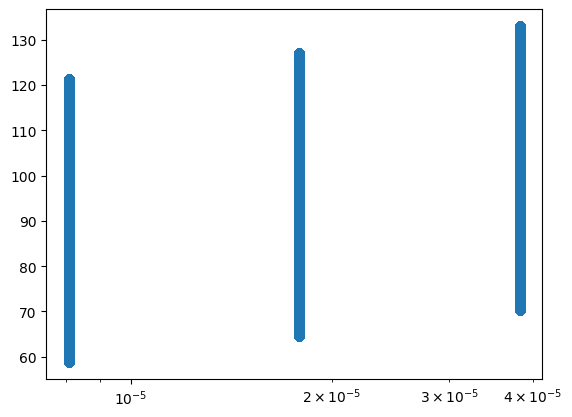

In [12]:
plt.scatter(area, psrr)
#plt.scatter(area[mask], psrr[mask])
plt.xscale('log')